In [1]:
#importing python modules and packages
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import contextily as cx
import proj as prj
import rasterio as rio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterstats import zonal_stats
from rasterstats import gen_zonal_stats
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import xyzservices.providers as xyz
pd.set_option('display.max_columns', None)

## Neighborhood


In [2]:
#reading neighborhood data,with floodzone ratio
neighborhood_FL = gpd.read_file('../data/Floodzones/neighborhood_floodzoneratio.shp')
neighborhood_FL.head()
#has only 371 counties

,State,County,City,Name,RegionID,Shape_Leng,Shape_Area,1in100,1in500,geometry
0,FL,Orange,Orlando,Alafaya,15046,0.551708,0.009048,0.219424,0.285221,"POLYGON ((-81.11414 28.47162, -81.11413 28.471..."
1,FL,Broward,Hollywood,Hillcrest,25125,0.055430,0.000146,0.240506,0.363973,"POLYGON ((-80.19527 25.99527, -80.19519 25.997..."
2,FL,Miami-Dade,Miami,Brickell,55477,0.086324,0.000260,0.112576,0.175456,"POLYGON ((-80.19729 25.76873, -80.19681 25.768..."
3,FL,Pasco,New Port Richey,North Park,116942,0.039007,0.000065,0.083825,0.087470,"POLYGON ((-82.70738 28.25927, -82.70726 28.259..."
4,FL,Volusia,New Smyrna Beach,South West,121790,0.100864,0.000253,0.281463,0.471792,"POLYGON ((-80.93372 29.01789, -80.93372 29.018..."


<Axes: >

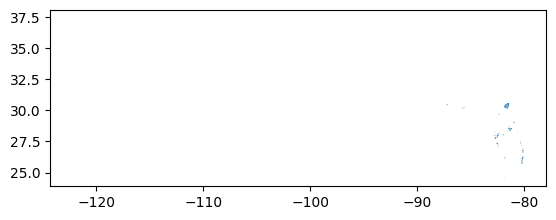

In [3]:
neighborhood_FL.plot()

In [4]:
#changing data type of RegionID to merge later
neighborhood_FL['RegionID'] = neighborhood_FL['RegionID'].astype(int)
print (neighborhood_FL.County.nunique())
#print (gdf_neighborhood.info())
#gdf_neighborhood.plot()

27


In [5]:
#reading Zillow Home Values Index for Neighborhood
ZHVI_neighborhood = pd.read_csv('../data/Neighborhood_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')

#filtering florida
ZHVI_neighborhood = ZHVI_neighborhood[ZHVI_neighborhood['State'] == "FL"]
ZHVI_neighborhood['CountyName'] = ZHVI_neighborhood['CountyName'].apply(lambda x: x.rsplit(' ', 1)[0])
ZHVI_neighborhood.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,2000-06-30,2000-07-31,2000-08-31,2000-09-30,2000-10-31,2000-11-30,2000-12-31,2001-01-31,2001-02-28,2001-03-31,2001-04-30,2001-05-31,2001-06-30,2001-07-31,2001-08-31,2001-09-30,2001-10-31,2001-11-30,2001-12-31,2002-01-31,2002-02-28,2002-03-31,2002-04-30,2002-05-31,2002-06-30,2002-07-31,2002-08-31,2002-09-30,2002-10-31,2002-11-30,2002-12-31,2003-01-31,2003-02-28,2003-03-31,2003-04-30,2003-05-31,2003-06-30,2003-07-31,2003-08-31,2003-09-30,2003-10-31,2003-11-30,2003-12-31,2004-01-31,2004-02-29,2004-03-31,2004-04-30,2004-05-31,2004-06-30,2004-07-31,2004-08-31,2004-09-30,2004-10-31,2004-11-30,2004-12-31,2005-01-31,2005-02-28,2005-03-31,2005-04-30,2005-05-31,2005-06-30,2005-07-31,2005-08-31,2005-09-30,2005-10-31,2005-11-30,2005-12-31,2006-01-31,2006-02-28,2006-03-31,2006-04-30,2006-05-31,2006-06-30,2006-07-31,2006-08-31,2006-09-30,2006-10-31,2006-11-30,2006-12-31,2007-01-31,2007-02-28,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,2008-01-31,2008-02-29,2008-03-31,2008-04-30,2008-05-31,2008-06-30,2008-07-31,2008-08-31,2008-09-30,2008-10-31,2008-11-30,2008-12-31,2009-01-31,2009-02-28,2009-03-31,2009-04-30,2009-05-31,2009-06-30,2009-07-31,2009-08-31,2009-09-30,2009-10-31,2009-11-30,2009-12-31,2010-01-31,2010-02-28,2010-03-31,2010-04-30,2010-05-31,2010-06-30,2010-07-31,2010-08-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-01-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,2011-06-30,2011-07-31,2011-08-31,2011-09-30,2011-10-31,2011-11-30,2011-12-31,2012-01-31,2012-02-29,2012-03-31,2012-04-30,2012-05-31,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,2013-08-31,2013-09-30,2013-10-31,2013-11-30,2013-12-31,2014-01-31,2014-02-28,2014-03-31,2014-04-30,2014-05-31,2014-06-30,2014-07-31,2014-08-31,2014-09-30,2014-10-31,2014-11-30,2014-12-31,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,2015-11-30,2015-12-31,2016-01-31,2016-02-29,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31,2017-01-31,2017-02-28,2017-03-31,2017-04-30,2017-05-31,2017-06-30,2017-07-31,2017-08-31,2017-09-30,2017-10-31,2017-11-30,2017-12-31,2018-01-31,2018-02-28,2018-03-31,2018-04-30,2018-05-31,2018-06-30,2018-07-31,2018-08-31,2018-09-30,2018-10-31,2018-11-30,2018-12-31,2019-01-31,2019-02-28,2019-03-31,2019-04-30,2019-05-31,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31
52,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",Orange,171436.243312,171816.273344,172451.491027,173497.255161,174711.441618,175852.457123,177174.438049,178612.802052,180218.941566,181899.105333,183551.393090,185131.854498,186506.057585,187645.300561,188675.430150,189848.356299,191320.316663,192825.478172,194181.228578,195410.279374,196510.223483,197725.131243,198853.093920,199992.905546,200902.303598,201745.804522,202549.525228,203369.747625,204264.239000,205381.728218,206673.613535,208209.615528,209638.954110,211134.531482,212507.363836,213869.709368,215130.395592,216261.947613,217547.267471,219045.500068,220632.861851,222158.130463,223601.757562,224987.212630,226092.407437,227167.979956,228496.414618,230066.476073,231589.825861,233063.356902,234632.857420,236630.985632,238890.395642,241486.346815,244297.615

In [6]:
#checking number of FL neighborhood in dataframe
print (ZHVI_neighborhood.RegionID.nunique())
print (ZHVI_neighborhood.info())

2248
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2248 entries, 52 to 21856
Columns: 288 entries, RegionID to 2023-03-31
dtypes: float64(279), int64(2), object(7)
memory usage: 5.0+ MB
None


#### Taking yearly average of home index values

In [7]:
#removing month and date from columns
for col in ZHVI_neighborhood.iloc[:, 9:].columns:
    ZHVI_neighborhood.rename(columns={col:col[0:4]},inplace=True)
print (ZHVI_neighborhood.columns)

Index(['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName',
       'State', 'City', 'Metro', 'CountyName', '2000',
       ...
       '2022', '2022', '2022', '2022', '2022', '2022', '2022', '2023', '2023',
       '2023'],
      dtype='object', length=288)


In [8]:
# yearly mean calculation for year columns only
year_only =  ZHVI_neighborhood.iloc[:,9:]
yearly_mean = year_only.groupby(level=0,axis=1).mean()

In [9]:
# concating yearly mean with rest of zhvi columns
zhvi_n = pd.concat([(ZHVI_neighborhood.iloc[:, 0:8]),yearly_mean], axis =1)
display (zhvi_n.head())                   

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
52,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",177196.141348,193291.150131,206687.261337,222599.029278,244726.810935,305999.456645,386548.387657,370623.515716,298109.011991,225637.025668,204715.032999,187845.366291,191702.394224,221287.234495,251894.148158,265014.376969,281208.330584,299661.294574,319900.350122,332666.734710,347846.351456,385652.530232,447293.885714,449117.123993
72,25372,72,Kendall,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,291682.624114,306548.735528,330571.390847,337365.367324,348564.987310,389364.548306,457624.630843,474528.578410
81,31789,81,Golden Gate,neighborhood,FL,FL,Naples,"Naples-Marco Island, FL",137181.615799,153671.126402,172954.637867,195598.218823,225137.397765,302992.680581,382182.668014,369537.838653,290824.099888,185748.202121,161967.328259,150246.964998,149357.322488,173789.986422,205171.836424,241959.361499,277786.976142,292463.119794,306020.523782,320069.296460,334546.936395,396415.891871,494121.977552,500775.269724
148,124381,150,Flagami,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",84395.864198,92381.703497,104735.135784,122522.909376,144105.477357,181785.679435,224151.315861,237570.742483,199779.507208,137283.514352,116522.511410,103226.841018,103792.859872,123722.912642,145803.786240,169490.495089,195624.628176,219190.958956,242191.702786,256942.374326,276470.453941,311783.520822,373291.450560,400405.204235
166,269072,168,Little Havana,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",49015.982121,52388.388264,58776.028562,67618.281020,80283.238789,104335.310097,129068.947550,134979.502080,113979.521757,85327.209068,65097.363203,56581.945261,58592.531285,72507.128407,90065.001656,107312.144733,123870.626912,138161.328104,156887.664106,167655.043318,179775.779361,203133.909101,269100.333011,293675.456158


In [10]:
#checking number of null values 
noPrice_2000 = zhvi_n[zhvi_n['2000'].isna()]
print (noPrice_2000.shape[0], " number of neighborhoods have no price for the year 2000")

950  number of neighborhoods have no price for the year 2000


In [11]:
# dropping rows with null values for 2000
zhvi_n.dropna(subset = '2000', inplace = True)

In [12]:
#merging zhvi_neighborhood with neighborhood boundaries of florida
zhvi_n_df = zhvi_n.merge(neighborhood_FL[['1in100', '1in500', 'geometry', 'RegionID']],left_on='RegionID', right_on = 'RegionID')
zhvi_n_df = gpd.GeoDataFrame(zhvi_n_df, geometry = 'geometry')
zhvi_n_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,1in100,1in500,geometry
0,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",177196.141348,193291.150131,206687.261337,222599.029278,244726.810935,305999.456645,386548.387657,370623.515716,298109.011991,225637.025668,204715.032999,187845.366291,191702.394224,221287.234495,251894.148158,265014.376969,281208.330584,299661.294574,319900.350122,332666.734710,347846.351456,385652.530232,447293.885714,449117.123993,0.219424,0.285221,"POLYGON ((-81.11414 28.47162, -81.11413 28.471..."
1,124381,150,Flagami,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",84395.864198,92381.703497,104735.135784,122522.909376,144105.477357,181785.679435,224151.315861,237570.742483,199779.507208,137283.514352,116522.511410,103226.841018,103792.859872,123722.912642,145803.786240,169490.495089,195624.628176,219190.958956,242191.702786,256942.374326,276470.453941,311783.520822,373291.450560,400405.204235,0.335167,0.512971,"POLYGON ((-80.24146 25.79374, -80.24018 25.792..."
2,269072,168,Little Havana,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",49015.982121,52388.388264,58776.028562,67618.281020,80283.238789,104335.310097,129068.947550,134979.502080,113979.521757,85327.209068,65097.363203,56581.945261,58592.531285,72507.128407,90065.001656,107312.144733,123870.626912,138161.328104,156887.664106,167655.043318,179775.779361,203133.909101,269100.333011,293675.456158,0.298584,0.439440,"POLYGON ((-80.21448 25.78252, -80.21375 25.782..."
3,269228,231,Alameda - West Flagler,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",102392.874664,112323.336503,127048.231204,150048.174259,180458.461724,227672.376890,277030.733588,288276.894115,236637.534695,163894.798699,141918.446684,130336.560438,128452.956624,150226.174002,173889.849311,204933.226302,235032.494823,259800.144912,281418.100736,301226.209714,327273.580949,371103.508260,447147.189527,474287.318351,0.160301,0.296925,"POLYGON ((-80.23116 25.77915, -80.23115 25.778..."
4,123423,238,Allapattah,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",56158.149368,62262.818677,68510.284290,82662.728702,97103.589089,122317.260226,153739.795865,165256.279767,141263.405257,98838.174477,70171.583946,53421.773254,51031.439585,61749.441672,77900.840212,95935.836924,114414.283114,138238.955246,164419.168936,187211.758965,214671.062598,250556.723225,308774.526891,338416.409544,0.302776,0.447183,"POLYGON ((-80.20589 25.81227, -80.20597 25.810..."


In [13]:
#changing projection to NAD83 / Florida GDL Albers
zhvi_n_df = zhvi_n_df.to_crs(epsg=3086)

In [16]:
#percentage chnage from 2000 to february 2023
zhvi_n_df['%Change'] = (zhvi_n_df['2023'] - zhvi_n_df['2000'])/zhvi_n_df['2000']
zhvi_n_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,1in100,1in500,geometry,%Change
0,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",177196.141348,193291.150131,206687.261337,222599.029278,244726.810935,305999.456645,386548.387657,370623.515716,298109.011991,225637.025668,204715.032999,187845.366291,191702.394224,221287.234495,251894.148158,265014.376969,281208.330584,299661.294574,319900.350122,332666.734710,347846.351456,385652.530232,447293.885714,449117.123993,0.219424,0.285221,"POLYGON ((682004.282 499472.199, 682004.684 49...",1.534576
1,124381,150,Flagami,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",84395.864198,92381.703497,104735.135784,122522.909376,144105.477357,181785.679435,224151.315861,237570.742483,199779.507208,137283.514352,116522.511410,103226.841018,103792.859872,123722.912642,145803.786240,169490.495089,195624.628176,219190.958956,242191.702786,256942.374326,276470.453941,311783.520822,373291.450560,400405.204235,0.335167,0.512971,"POLYGON ((776318.677 204596.862, 776449.612 20...",3.744370
2,269072,168,Little Havana,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",49015.982121,52388.388264,58776.028562,67618.281020,80283.238789,104335.310097,129068.947550,134979.502080,113979.521757,85327.209068,65097.363203,56581.945261,58592.531285,72507.128407,90065.001656,107312.144733,123870.626912,138161.328104,156887.664106,167655.043318,179775.779361,203133.909101,269100.333011,293675.456158,0.298584,0.439440,"POLYGON ((779057.297 203435.114, 779130.981 20...",4.991422
3,269228,231,Alameda - West Flagler,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",102392.874664,112323.336503,127048.231204,150048.174259,180458.461724,227672.376890,277030.733588,288276.894115,236637.534695,163894.798699,141918.446684,130336.560438,128452.956624,150226.174002,173889.849311,204933.226302,235032.494823,259800.144912,281418.100736,301226.209714,327273.580949,371103.508260,447147.189527,474287.318351,0.160301,0.296925,"POLYGON ((777399.006 203010.111, 777401.218 20...",3.632034
4,123423,238,Allapattah,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",56158.149368,62262.818677,68510.284290,82662.728702,97103.589089,122317.260226,153739.795865,165256.279767,141263.405257,98838.174477,70171.583946,53421.773254,51031.439585,61749.441672,77900.840212,95935.836924,114414.283114,138238.955246,164419.168936,187211.758965,214671.062598,250556.723225,308774.526891,338416.409544,0.302776,0.447183,"POLYGON ((779815.590 206760.914, 779813.473 20...",5.026132


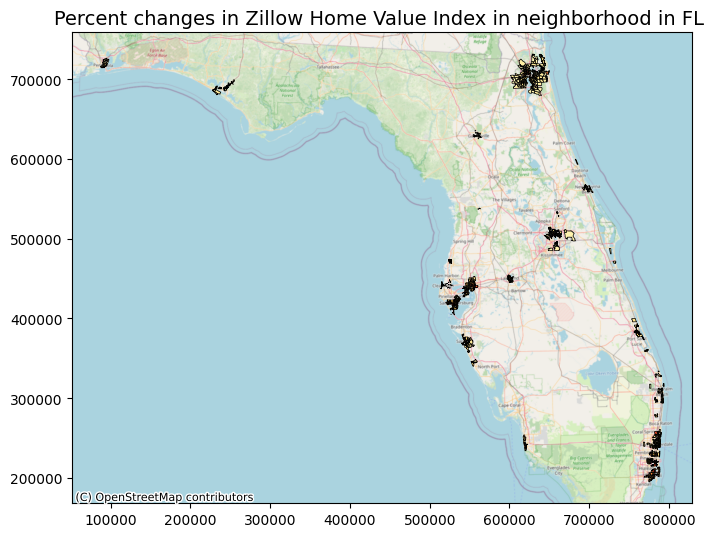

In [17]:
#plotting percent changes
ax1 = zhvi_n_df.plot(column = '%Change', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax1, source=xyz.OpenStreetMap.Mapnik, crs=zhvi_n_df.crs)
ax1.set_title('Percent changes in Zillow Home Value Index in neighborhood in FL ',  fontdict={'fontsize': '14', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/ZHVI_percentChangeNeighborhood.pdf')

### Mapping nearest distance from coast to neighborhood centroid

In [18]:
#assigning new dataframe by deep copy to create centroid of neighborhood polygons
zhvi_centroid = zhvi_n_df.copy()
#calculating centroid of the polygons in geodataframe 
zhvi_centroid["centroid"] = zhvi_centroid["geometry"].centroid
#zhvi_centroid.head()

In [19]:
#reading coastline shp into geodataframe
coastline = gpd.read_file('../data/tl_2022_us_coastline/tl_2022_us_coastline_epsg3086.shp')
coastline = coastline.to_crs(epsg = 3086)
display (coastline.head())
print (coastline.crs)

,NAME,MTFCC,geometry
0,Atlántico,L4150,"LINESTRING (2314644.768 -470812.051, 2314611.0..."
1,Gulf,L4150,"LINESTRING (-662077.698 671170.887, -662051.59..."
2,Gulf,L4150,"LINESTRING (281592.358 630663.792, 281632.754 ..."
3,Gulf,L4150,"LINESTRING (-298714.596 621005.621, -298688.34..."
4,Gulf,L4150,"LINESTRING (-719284.455 587719.003, -719289.84..."


EPSG:3086


#### joining centroid with nearest coastline

In [20]:
#creating series with centroid value only 
centroid = zhvi_centroid["centroid"] 

#dropping polygon geometry column to avoid duplicate geometry columns
zhvi_centroid.drop(columns = ['geometry'], inplace = True)
zhvi_centroid.rename(columns = {'centroid': 'geometry'}, inplace = True)
zhvi_centroid.set_geometry(centroid, inplace = True)

In [21]:
print (zhvi_centroid.shape)

(911, 36)


In [22]:
#using sjoin_nearest to calculate nearest distance from centroid to coastline
zhvi_n_w_coastline = gpd.sjoin_nearest(zhvi_centroid, coastline, distance_col="distances")
print (zhvi_n_w_coastline.shape)
zhvi_n_w_coastline.head() 

(914, 40)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,1in100,1in500,%Change,geometry,index_right,NAME,MTFCC,distances
0,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",177196.141348,193291.150131,206687.261337,222599.029278,244726.810935,305999.456645,386548.387657,370623.515716,298109.011991,225637.025668,204715.032999,187845.366291,191702.394224,221287.234495,251894.148158,265014.376969,281208.330584,299661.294574,319900.350122,332666.734710,347846.351456,385652.530232,447293.885714,449117.123993,0.219424,0.285221,1.534576,POINT (675658.321 504495.910),1571,Atlantic,L4150,52801.474949
7,125257,319,Meadow Woods,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",152982.671114,164900.825475,177676.796962,188225.183399,207106.190021,254332.179047,325504.935180,328741.327777,259477.460105,171021.540365,147461.551632,135061.913785,140996.629274,166505.288102,194010.975388,211434.081498,231664.734167,250146.927059,269564.209130,285232.906504,299265.719286,337385.963211,400291.069580,401780.002146,0.338590,0.397005,1.626311,POINT (659534.841 487651.089),1571,Atlantic,L4150,72487.435761
24,124797,879,Hunters Creek,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",193180.395744,205583.951298,216645.942095,228540.367430,251989.948945,319668.512620,402177.925244,391001.046882,316747.307613,234187.919716,210964.153061,197015.668421,205052.835906,239064.546245,271720.249729,282627.025374,293925.137528,308780.298049,326236.540170,336532.416026,350946.350091,392098.343897,460432.217993,464500.549936,0.236931,0.288979,1.404491,POINT (651426.750 486515.966),1571,Atlantic,L4150,80551.623062
171,126230,4053,South Patrick Shores,neighborhood,FL,FL,Satellite Beach,"Palm Bay-Melbourne-Titusville, FL",155702.500496,167259.857014,189733.020849,218650.652909,267836.009326,354978.758812,386967.457192,336289.687832,265452.620535,216694.268014,200364.464874,184128.756050,186980.633132,209568.573840,228352.475366,246673.163813,268973.397789,297169.194593,319227.379154,322952.497255,338439.774728,389311.176445,459238.920898,465692.570987,0.201406,0.277598,1.990913,POINT (731695.334 470746.874),1571,Atlantic,L4150,1818.948865
344,126242,7964,Southchase,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",187756.697423,202310.686508,215957.689000,229834.072447,254415.355524,324862.322369,416406.222875,402583.492614,321362.610624,221762.151340,187423.297053,177758.834211,186137.659898,212795.676543,244696.979770,257058.669664,272784.634448,290599.176748,306999.691190,320832.874987,338268.186202,366241.129573,410101.894897,415673.473652,0.234548,0.323828,1.213894,POINT (656043.079 489929.523),1571,Atlantic,L4150,76082.913659


In [23]:
duplicate = zhvi_n_w_coastline[zhvi_n_w_coastline.duplicated('RegionName')]
duplicated_regionname = duplicate['RegionName']
#zhvi_w_coastline[zhvi_w_coastline['RegionName'].isin(duplicated_regionname)]

In [24]:
#dropping duplicates 
zhvi_n_w_coastline.drop_duplicates(subset = 'distances', inplace = True)
print (zhvi_n_w_coastline.shape)
zhvi_n_w_coastline.head()

(896, 40)


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,1in100,1in500,%Change,geometry,index_right,NAME,MTFCC,distances
0,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",177196.141348,193291.150131,206687.261337,222599.029278,244726.810935,305999.456645,386548.387657,370623.515716,298109.011991,225637.025668,204715.032999,187845.366291,191702.394224,221287.234495,251894.148158,265014.376969,281208.330584,299661.294574,319900.350122,332666.734710,347846.351456,385652.530232,447293.885714,449117.123993,0.219424,0.285221,1.534576,POINT (675658.321 504495.910),1571,Atlantic,L4150,52801.474949
7,125257,319,Meadow Woods,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",152982.671114,164900.825475,177676.796962,188225.183399,207106.190021,254332.179047,325504.935180,328741.327777,259477.460105,171021.540365,147461.551632,135061.913785,140996.629274,166505.288102,194010.975388,211434.081498,231664.734167,250146.927059,269564.209130,285232.906504,299265.719286,337385.963211,400291.069580,401780.002146,0.338590,0.397005,1.626311,POINT (659534.841 487651.089),1571,Atlantic,L4150,72487.435761
24,124797,879,Hunters Creek,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",193180.395744,205583.951298,216645.942095,228540.367430,251989.948945,319668.512620,402177.925244,391001.046882,316747.307613,234187.919716,210964.153061,197015.668421,205052.835906,239064.546245,271720.249729,282627.025374,293925.137528,308780.298049,326236.540170,336532.416026,350946.350091,392098.343897,460432.217993,464500.549936,0.236931,0.288979,1.404491,POINT (651426.750 486515.966),1571,Atlantic,L4150,80551.623062
171,126230,4053,South Patrick Shores,neighborhood,FL,FL,Satellite Beach,"Palm Bay-Melbourne-Titusville, FL",155702.500496,167259.857014,189733.020849,218650.652909,267836.009326,354978.758812,386967.457192,336289.687832,265452.620535,216694.268014,200364.464874,184128.756050,186980.633132,209568.573840,228352.475366,246673.163813,268973.397789,297169.194593,319227.379154,322952.497255,338439.774728,389311.176445,459238.920898,465692.570987,0.201406,0.277598,1.990913,POINT (731695.334 470746.874),1571,Atlantic,L4150,1818.948865
344,126242,7964,Southchase,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",187756.697423,202310.686508,215957.689000,229834.072447,254415.355524,324862.322369,416406.222875,402583.492614,321362.610624,221762.151340,187423.297053,177758.834211,186137.659898,212795.676543,244696.979770,257058.669664,272784.634448,290599.176748,306999.691190,320832.874987,338268.186202,366241.129573,410101.894897,415673.473652,0.234548,0.323828,1.213894,POINT (656043.079 489929.523),1571,Atlantic,L4150,76082.913659


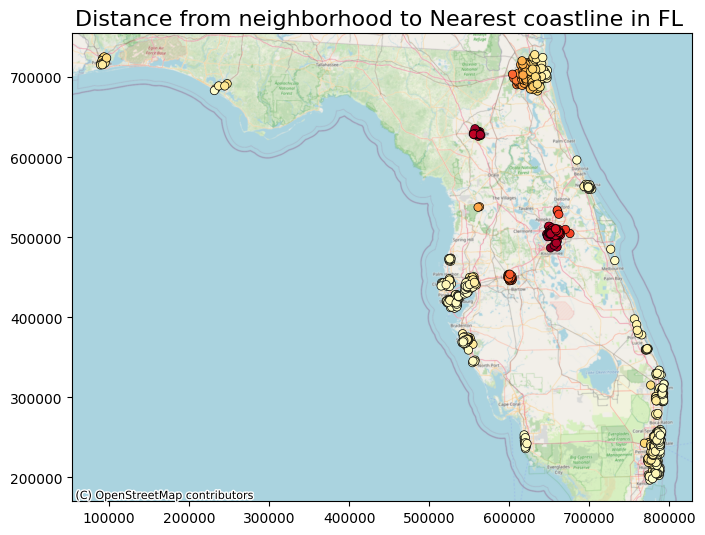

In [25]:
#plotting distance to coast from neighborhood centroids
ax2 = zhvi_n_w_coastline.plot(column = 'distances', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax2, source=xyz.OpenStreetMap.Mapnik, crs=zhvi_n_w_coastline.crs)
ax2.set_title('Distance from neighborhood to Nearest coastline in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/ZHVI_distanceFromNeighborhood.pdf')

### Calculating mean elevation in each neighborhood using DEM

In [26]:
FL_dem = rio.open('../data/FL_DEM/FL_DEM/resampled_reproj_flidar_mosaic_in.tif')
show(FL_dem)

#assigning dataframe as new variable
shp = zhvi_n_df

#reading raster datasetReader as an array
array = FL_dem.read(1)
affine = FL_dem.transform

In [27]:
#including nodata in statistics list to know how many pixels are nodata values so that statistics is not incorrect
stats = zonal_stats(shp, 
                    array, 
                    affine=affine, 
                    stats=['mean', 'nodata'],
                   geojson_out=True
                    )
print (type(stats[0]))

C:\Users\aadyab\AppData\Local\anaconda3\envs\env1\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


<class 'dict'>


In [28]:
#extracting zonal stats only from the stats dictionary
mean_ele =  []

i = 0

while i < len(stats):
    mean_ele.append((stats[i]['properties']))
    i = i + 1

In [30]:
#creating dataframe from mean elevation
df = pd.DataFrame(mean_ele)
df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,1in100,1in500,%Change,mean,nodata
0,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",177196.141348,193291.150131,206687.261337,222599.029278,244726.810935,305999.456645,386548.387657,370623.515716,298109.011991,225637.025668,204715.032999,187845.366291,191702.394224,221287.234495,251894.148158,265014.376969,281208.330584,299661.294574,319900.350122,332666.734710,347846.351456,385652.530232,447293.885714,449117.123993,0.219424,0.285221,1.534576,742.749807,0.0
1,124381,150,Flagami,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",84395.864198,92381.703497,104735.135784,122522.909376,144105.477357,181785.679435,224151.315861,237570.742483,199779.507208,137283.514352,116522.511410,103226.841018,103792.859872,123722.912642,145803.786240,169490.495089,195624.628176,219190.958956,242191.702786,256942.374326,276470.453941,311783.520822,373291.450560,400405.204235,0.335167,0.512971,3.744370,286.271004,0.0
2,269072,168,Little Havana,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",49015.982121,52388.388264,58776.028562,67618.281020,80283.238789,104335.310097,129068.947550,134979.502080,113979.521757,85327.209068,65097.363203,56581.945261,58592.531285,72507.128407,90065.001656,107312.144733,123870.626912,138161.328104,156887.664106,167655.043318,179775.779361,203133.909101,269100.333011,293675.456158,0.298584,0.439440,4.991422,223.888380,0.0
3,269228,231,Alameda - West Flagler,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",102392.874664,112323.336503,127048.231204,150048.174259,180458.461724,227672.376890,277030.733588,288276.894115,236637.534695,163894.798699,141918.446684,130336.560438,128452.956624,150226.174002,173889.849311,204933.226302,235032.494823,259800.144912,281418.100736,301226.209714,327273.580949,371103.508260,447147.189527,474287.318351,0.160301,0.296925,3.632034,124.144041,0.0
4,123423,238,Allapattah,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",56158.149368,62262.818677,68510.284290,82662.728702,97103.589089,122317.260226,153739.795865,165256.279767,141263.405257,98838.174477,70171.583946,53421.773254,51031.439585,61749.441672,77900.840212,95935.836924,114414.283114,138238.955246,164419.168936,187211.758965,214671.062598,250556.723225,308774.526891,338416.409544,0.302776,0.447183,5.026132,218.048796,0.0


In [31]:
#merging meanelevation into neighborhood geodataframe
zhvi_n_df = pd.merge(zhvi_n_df, df[['RegionName','mean']], on ='RegionName', how='left')
zhvi_n_df.rename(columns={"mean": "meanEle"}, inplace = True)
zhvi_n_df.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,1in100,1in500,geometry,%Change,meanEle
0,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",177196.141348,193291.150131,206687.261337,222599.029278,244726.810935,305999.456645,386548.387657,370623.515716,298109.011991,225637.025668,204715.032999,187845.366291,191702.394224,221287.234495,251894.148158,265014.376969,281208.330584,299661.294574,319900.350122,332666.734710,347846.351456,385652.530232,447293.885714,449117.123993,0.219424,0.285221,"POLYGON ((682004.282 499472.199, 682004.684 49...",1.534576,742.749807
1,124381,150,Flagami,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",84395.864198,92381.703497,104735.135784,122522.909376,144105.477357,181785.679435,224151.315861,237570.742483,199779.507208,137283.514352,116522.511410,103226.841018,103792.859872,123722.912642,145803.786240,169490.495089,195624.628176,219190.958956,242191.702786,256942.374326,276470.453941,311783.520822,373291.450560,400405.204235,0.335167,0.512971,"POLYGON ((776318.677 204596.862, 776449.612 20...",3.744370,286.271004
2,269072,168,Little Havana,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",49015.982121,52388.388264,58776.028562,67618.281020,80283.238789,104335.310097,129068.947550,134979.502080,113979.521757,85327.209068,65097.363203,56581.945261,58592.531285,72507.128407,90065.001656,107312.144733,123870.626912,138161.328104,156887.664106,167655.043318,179775.779361,203133.909101,269100.333011,293675.456158,0.298584,0.439440,"POLYGON ((779057.297 203435.114, 779130.981 20...",4.991422,223.888380
3,269228,231,Alameda - West Flagler,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",102392.874664,112323.336503,127048.231204,150048.174259,180458.461724,227672.376890,277030.733588,288276.894115,236637.534695,163894.798699,141918.446684,130336.560438,128452.956624,150226.174002,173889.849311,204933.226302,235032.494823,259800.144912,281418.100736,301226.209714,327273.580949,371103.508260,447147.189527,474287.318351,0.160301,0.296925,"POLYGON ((777399.006 203010.111, 777401.218 20...",3.632034,124.144041
4,123423,238,Allapattah,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",56158.149368,62262.818677,68510.284290,82662.728702,97103.589089,122317.260226,153739.795865,165256.279767,141263.405257,98838.174477,70171.583946,53421.773254,51031.439585,61749.441672,77900.840212,95935.836924,114414.283114,138238.955246,164419.168936,187211.758965,214671.062598,250556.723225,308774.526891,338416.409544,0.302776,0.447183,"POLYGON ((779815.590 206760.914, 779813.473 20...",5.026132,218.048796


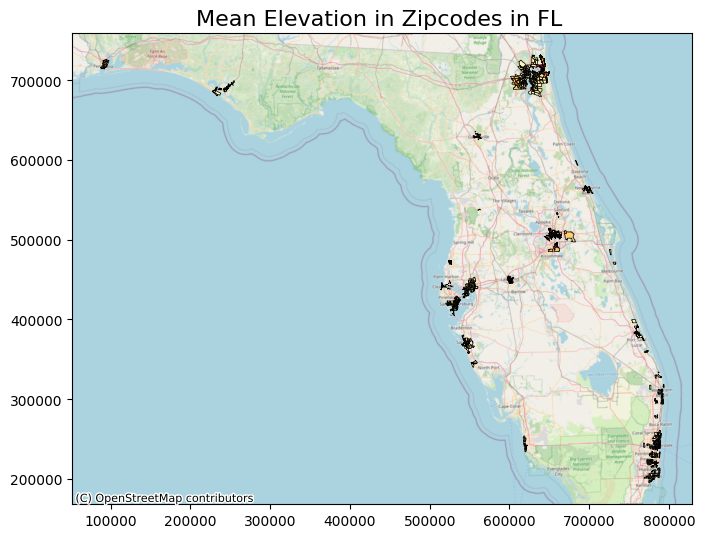

In [32]:
#plotting zipcode wise mean elevation 
ax3 = zhvi_n_df.plot(column = 'meanEle', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax3, source=xyz.OpenStreetMap.Mapnik, crs=zhvi_n_df.crs)
ax3.set_title('Mean Elevation in Zipcodes in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/MeanElevationNeighborhood.pdf')

In [36]:
#### Combining all data into single geodataframe
final_neighborhood = pd.merge(zhvi_n_df,zhvi_n_w_coastline[['RegionName','distances']],on='RegionName', how='left')
final_neighborhood.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,1in100,1in500,geometry,%Change,meanEle,distances
0,15046,52,Alafaya,neighborhood,FL,FL,Orlando,"Orlando-Kissimmee-Sanford, FL",177196.141348,193291.150131,206687.261337,222599.029278,244726.810935,305999.456645,386548.387657,370623.515716,298109.011991,225637.025668,204715.032999,187845.366291,191702.394224,221287.234495,251894.148158,265014.376969,281208.330584,299661.294574,319900.350122,332666.734710,347846.351456,385652.530232,447293.885714,449117.123993,0.219424,0.285221,"POLYGON ((682004.282 499472.199, 682004.684 49...",1.534576,742.749807,52801.474949
1,124381,150,Flagami,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",84395.864198,92381.703497,104735.135784,122522.909376,144105.477357,181785.679435,224151.315861,237570.742483,199779.507208,137283.514352,116522.511410,103226.841018,103792.859872,123722.912642,145803.786240,169490.495089,195624.628176,219190.958956,242191.702786,256942.374326,276470.453941,311783.520822,373291.450560,400405.204235,0.335167,0.512971,"POLYGON ((776318.677 204596.862, 776449.612 20...",3.744370,286.271004,6447.166154
2,269072,168,Little Havana,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",49015.982121,52388.388264,58776.028562,67618.281020,80283.238789,104335.310097,129068.947550,134979.502080,113979.521757,85327.209068,65097.363203,56581.945261,58592.531285,72507.128407,90065.001656,107312.144733,123870.626912,138161.328104,156887.664106,167655.043318,179775.779361,203133.909101,269100.333011,293675.456158,0.298584,0.439440,"POLYGON ((779057.297 203435.114, 779130.981 20...",4.991422,223.888380,3046.663545
3,269228,231,Alameda - West Flagler,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",102392.874664,112323.336503,127048.231204,150048.174259,180458.461724,227672.376890,277030.733588,288276.894115,236637.534695,163894.798699,141918.446684,130336.560438,128452.956624,150226.174002,173889.849311,204933.226302,235032.494823,259800.144912,281418.100736,301226.209714,327273.580949,371103.508260,447147.189527,474287.318351,0.160301,0.296925,"POLYGON ((777399.006 203010.111, 777401.218 20...",3.632034,124.144041,4814.589022
4,123423,238,Allapattah,neighborhood,FL,FL,Miami,"Miami-Fort Lauderdale-Pompano Beach, FL",56158.149368,62262.818677,68510.284290,82662.728702,97103.589089,122317.260226,153739.795865,165256.279767,141263.405257,98838.174477,70171.583946,53421.773254,51031.439585,61749.441672,77900.840212,95935.836924,114414.283114,138238.955246,164419.168936,187211.758965,214671.062598,250556.723225,308774.526891,338416.409544,0.302776,0.447183,"POLYGON ((779815.590 206760.914, 779813.473 20...",5.026132,218.048796,6055.564305


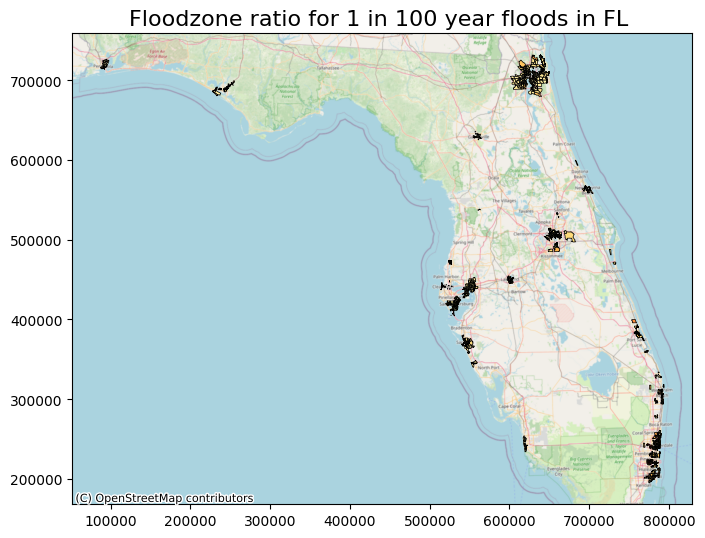

In [37]:
#plotting 1 in 100  floodzone ratio in neighborhood
ax4 = final_neighborhood.plot(column = '1in100', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax4, source=xyz.OpenStreetMap.Mapnik, crs=final_neighborhood.crs)
ax4.set_title('Floodzone ratio for 1 in 100 year floods in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/FZ1in100_ZNeighborhood.pdf')

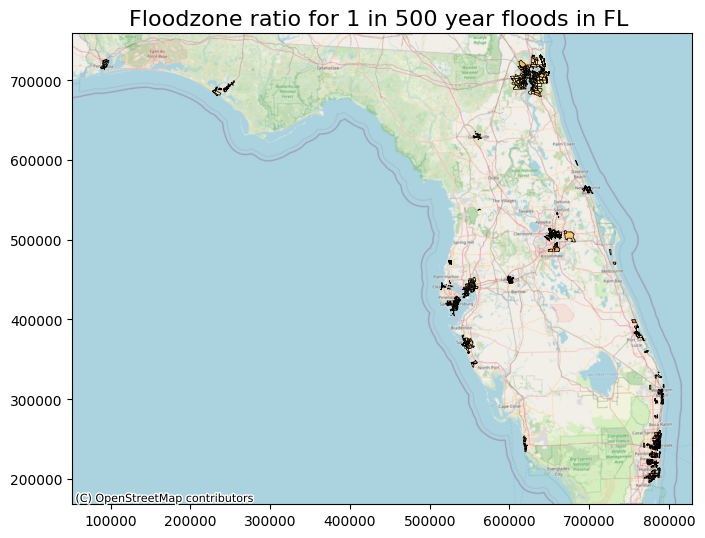

In [38]:
#plotting 1 in 500  floodzone ratio in neighborhood
ax5 = final_neighborhood.plot(column = '1in500', cmap = 'YlOrRd', linewidth= 0.5, edgecolor='k', figsize=(8,8))
cx.add_basemap(ax5, source=xyz.OpenStreetMap.Mapnik, crs=final_neighborhood.crs)
ax5.set_title('Floodzone ratio for 1 in 500 year floods in FL ',  fontdict={'fontsize': '16', 'fontweight' : '1'})
plt.savefig('../data/exportedMaps/FZ1in500_ZNeighborhood.pdf')

In [39]:
# exporting zillow home value index to shapefile to calculate flood ratio
final_neighborhood.to_file('../data/finalFiles/neighborhood_final.shp')